## Imports

In [1]:
import os
import re

import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from PIL import Image

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *

K.set_image_data_format('channels_last')

## Dataset

In [2]:
path = "../input/ultrasound-nerve-segmentation/train/"
file_list = os.listdir(path)
file_list[:20]

['35_63_mask.tif',
 '34_68_mask.tif',
 '22_46.tif',
 '26_80_mask.tif',
 '34_6_mask.tif',
 '13_43.tif',
 '22_34_mask.tif',
 '25_102_mask.tif',
 '13_110_mask.tif',
 '23_60.tif',
 '43_79_mask.tif',
 '29_114_mask.tif',
 '5_29_mask.tif',
 '26_60.tif',
 '44_42.tif',
 '46_66_mask.tif',
 '43_53_mask.tif',
 '7_74.tif',
 '32_114.tif',
 '27_103.tif']

In [3]:
train_image = []
train_mask = glob(path + '*_mask*')

for i in train_mask:
    train_image.append(i.replace('_mask', ''))
        
print(train_image[:10],"\n" ,train_mask[:10])

['../input/ultrasound-nerve-segmentation/train/35_63.tif', '../input/ultrasound-nerve-segmentation/train/34_68.tif', '../input/ultrasound-nerve-segmentation/train/26_80.tif', '../input/ultrasound-nerve-segmentation/train/34_6.tif', '../input/ultrasound-nerve-segmentation/train/22_34.tif', '../input/ultrasound-nerve-segmentation/train/25_102.tif', '../input/ultrasound-nerve-segmentation/train/13_110.tif', '../input/ultrasound-nerve-segmentation/train/43_79.tif', '../input/ultrasound-nerve-segmentation/train/29_114.tif', '../input/ultrasound-nerve-segmentation/train/5_29.tif'] 
 ['../input/ultrasound-nerve-segmentation/train/35_63_mask.tif', '../input/ultrasound-nerve-segmentation/train/34_68_mask.tif', '../input/ultrasound-nerve-segmentation/train/26_80_mask.tif', '../input/ultrasound-nerve-segmentation/train/34_6_mask.tif', '../input/ultrasound-nerve-segmentation/train/22_34_mask.tif', '../input/ultrasound-nerve-segmentation/train/25_102_mask.tif', '../input/ultrasound-nerve-segmentati

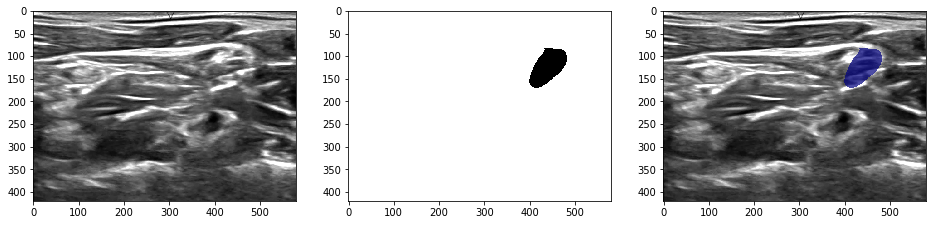

In [4]:
# Display the first image and mask of the first subject.
image1 = np.array(Image.open(path+"1_1.tif"))
image1_mask = np.array(Image.open(path+"1_1_mask.tif"))
image1_mask = np.ma.masked_where(image1_mask == 0, image1_mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(image1, cmap = 'gray')

ax[1].imshow(image1_mask, cmap = 'gray')

ax[2].imshow(image1, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

### Model

In [5]:
width = 128
height = 128

In [7]:
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [8]:
def res_block(x,filter_size):
    cb1 = Conv2D(filter_size,(3,3),padding = 'same',activation="relu")(x)
    cb2 = Conv2D(filter_size,(1,1),padding = 'same',activation="relu")(x)
    add = Add()([cb1,cb2])
    
    return add

def res_path(x,filter_size,path_number):
    skip_connection = res_block(x, filter_size)
    
    if path_number == 2:
        skip_connection = res_block(skip_connection,filter_size)
    
    elif path_number == 1:
        skip_connection = res_block(skip_connection,filter_size)
        skip_connection = res_block(skip_connection,filter_size)
    
    return skip_connection

def decoder_block(x, latent, out_channels):
    conv_options = {
        'activation':'relu',
        'padding':'same',
        'kernel_initializer':'he_normal',
        'data_format':'channels_last'  
    }
    
    db = UpSampling2D(size=(2, 2))(x)
    db = Conv2D(latent, 3, **conv_kwargs)(db)
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)
    return db

def get_VGGUnet(input_size=(512, 512, 1)):
    x = Input(input_size)
    inp = x
    input_shape = input_size
    
    if input_size[-1] < 3:
        inp = Conv2D(3, 1)(x)                         
        input_shape = (input_size[0], input_size[0], 3)  
    else:
        inp = x
        input_shape = input_size

    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inp)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    # Second encoder block
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    # Third encoder block
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)
    # Forth encoder block
    enc4 = MaxPooling2D(pool_size=(2, 2))(enc3)
    enc4 = encoder.get_layer(name='block4_conv1')(enc4)
    enc4 = encoder.get_layer(name='block4_conv2')(enc4)
    enc4 = encoder.get_layer(name='block4_conv3')(enc4)

    # Center block
    center = MaxPooling2D(pool_size=(2, 2))(enc4)
    center = decoder_block(center, 512, 256)

    # Decoder block to forth encoder
    res_path4 = res_path(enc4,256,4)
    dec4 = concatenate([res_path4, center], axis=3)
    dec4 = decoder_block(dec4, 512, 64)
    # Decoder block to third encoder
    res_path3 = res_path(enc3,128,3)
    dec3 = concatenate([res_path3, dec4], axis=3)
    dec3 = decoder_block(dec3, 256, 64)
    # Decoder block to second encoder
    res_path2 = res_path(enc2,64,2)
    dec2 = concatenate([res_path2, dec3], axis=3)
    dec2 = decoder_block(dec2, 128, 64)
    # Final Block concatenation with first encoded feature 
    res_path1 = res_path(enc1,32,1)
    dec1 = concatenate([res_path1, dec2], axis=3)
    dec1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(dec1)
    dec1 = ReLU()(dec1)

    # Output
    out = Conv2D(1, 1)(dec1)
    out = Activation('sigmoid')(out)  
    
    # Final model
    model = Model(inputs=[x], outputs=[out])
    
    return model

In [9]:
def train_generator(data_frame, batch_size, train_path, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [10]:
pos_mask = []
pos_img = []
neg_mask = []
neg_img = []

for mask_path, img_path in zip(train_mask, train_image):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if np.sum(mask) == 0:
        neg_mask.append(mask_path)
        neg_img.append(img_path)
    else:
        pos_mask.append(mask_path)
        pos_img.append(img_path)

In [11]:
!mkdir generated
!mkdir generated/img

In [12]:
def flip_up_down(img):
    newImg = img.copy()
    return cv2.flip(newImg, 0)

def flip_right_left(img):
    newImg = img.copy()
    return cv2.flip(newImg, 1)

In [13]:
gen_img = []
gen_mask = []

for (img_path, mask_path) in tqdm(zip(pos_img, pos_mask)):
    image_name = img_path.split('/')[-1].split('.')[0]

    uf_img_path = 'generated/img/'+image_name+'_uf.jpg'
    uf_mask_path = 'generated/img/'+image_name+'_uf_mask.jpg'
    rf_img_path = 'generated/img/'+image_name+'_rf.jpg'
    rf_mask_path = 'generated/img/'+image_name+'_rf_mask.jpg'

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    uf_img = flip_up_down(img)
    uf_mask = flip_up_down(mask)
    rf_img = flip_right_left(img)
    rf_mask = flip_right_left(mask)

    cv2.imwrite(uf_img_path, uf_img)
    cv2.imwrite(uf_mask_path, uf_mask)
    cv2.imwrite(rf_img_path, rf_img)
    cv2.imwrite(rf_mask_path, rf_mask)
    
    gen_img.append(uf_img_path)
    gen_mask.append(uf_mask_path)
    gen_img.append(rf_img_path)
    gen_mask.append(rf_mask_path)

2323it [00:52, 44.08it/s]


In [14]:
aug_img = gen_img + train_image
aug_mask = gen_mask + train_mask

df_ = pd.DataFrame(data={"filename": aug_img, 'mask' : aug_mask})
df = df_.sample(frac=1).reset_index(drop=True)

kf = KFold(n_splits = 5, shuffle=False)

In [15]:
histories = []
losses = []
accuracies = []
dicecoefs = []
jacards = []

EPOCHS = 50
BATCH_SIZE = 32

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

for k, (train_index, test_index) in enumerate(kf.split(df)):
    train_data_frame = df.iloc[train_index]
    test_data_frame = df.iloc[test_index]
    
    train_gen = train_generator(train_data_frame, BATCH_SIZE,
                                None,
                                train_generator_args,
                                target_size=(height, width))

    test_gen = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))

    model = get_VGGUnet(input_size=(height,width, 1))
    model.compile(optimizer=Adam(lr=5e-5), loss=dice_coef_loss, metrics=[jacard, dice_coef, 'binary_accuracy'])

    model_checkpoint = ModelCheckpoint(str(k+1) + '_unet_ner_seg.hdf5', verbose=1, save_best_only=True)

    history = model.fit(train_gen,
                        steps_per_epoch = len(train_data_frame) // BATCH_SIZE, 
                        epochs = EPOCHS, 
                        callbacks = [model_checkpoint],
                        validation_data = test_gen,
                        validation_steps = len(test_data_frame) // BATCH_SIZE)
    
    model = load_model(str(k+1) + '_unet_ner_seg.hdf5', custom_objects={
        'dice_coef_loss': dice_coef_loss,
        'jacard': jacard,
        'dice_coef': dice_coef
    })
    
    test_gen = train_generator(test_data_frame, BATCH_SIZE, None, {}, target_size=(height, width))
    results = model.evaluate(test_gen, steps=len(test_data_frame) // BATCH_SIZE)
    results = dict(zip(model.metrics_names,results))
    
    histories.append(history)
    accuracies.append(results['binary_accuracy'])
    losses.append(results['loss'])
    dicecoefs.append(results['dice_coef'])
    jacards.append(results['jacard'])
    

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/50
Found 8224 images.
Found 8224 images.
256/257 [============================>.] - ETA: 0s - loss: -0.5945 - jacard: 0.4335 - dice_coef: 0.5945 - binary_accuracy: 0.9785Found 2057 images.
Found 2057 images.
64/64 [==============================] - 23s 354ms/step - loss: -0.6800 - jacard: 0.5162 - dice_coef: 0.6800 - binary_accuracy: 0.9882

Epoch 00001: val_loss improved from inf to -0.68001, saving model to 1_unet_ner_seg.hdf5
257/257 [==============================] - 150s 584ms/step - loss: -0.5946 - jacard: 0.4335 - dice_coef: 0.5946 - binary_accuracy: 0.9786 - val_loss: -0.6800 - val_jacard: 0.5162 - val_dice_coef: 0.6800 - val_binary_accuracy: 0.9882
Epoch 2/50
64/64 [==============================] - 16s 247ms/step - loss: -0.7035 - jacard: 0.5446 - dice_coef: 0.7035 - binary_accuracy: 0.9888

Epoch 00002: val_loss improved from -0.680

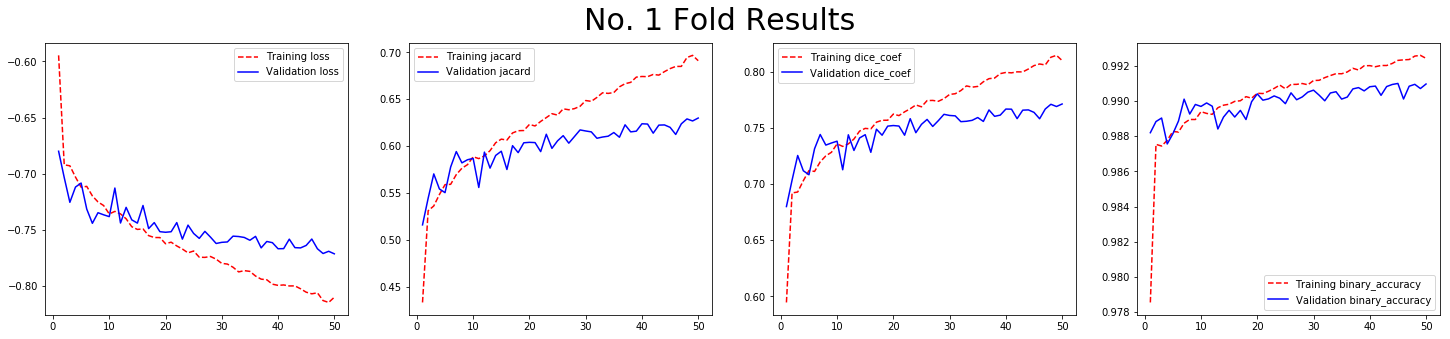

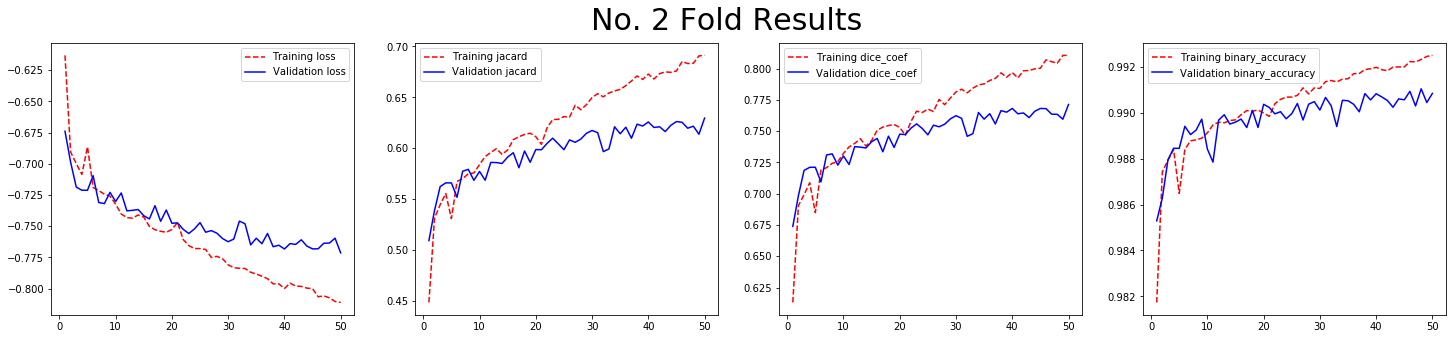

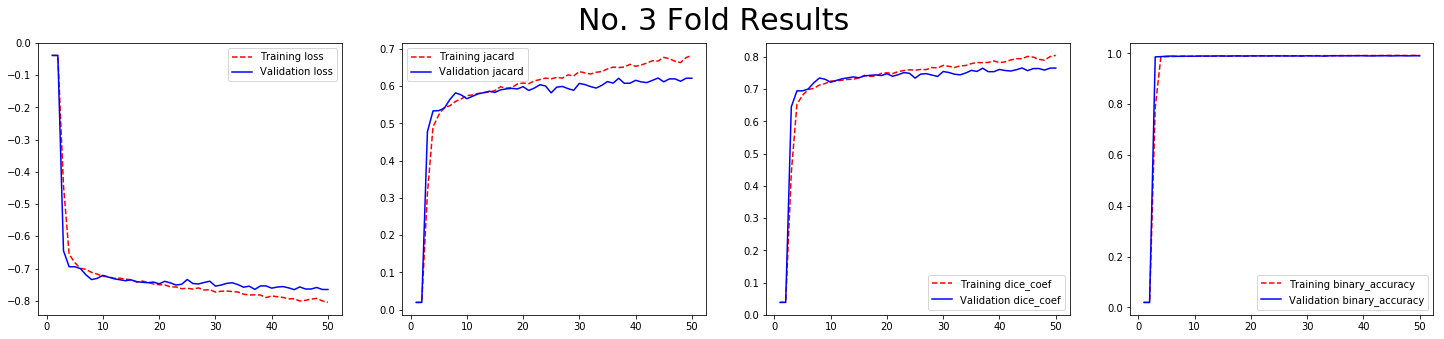

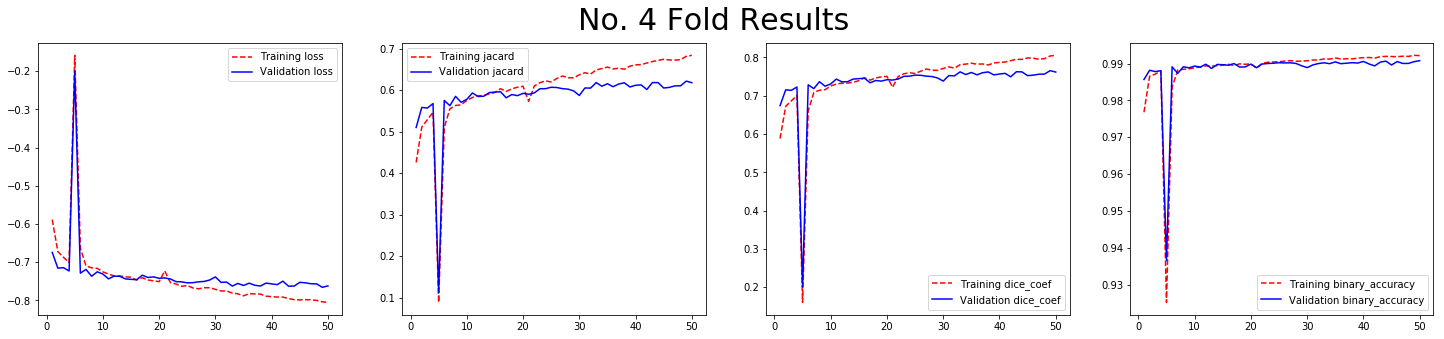

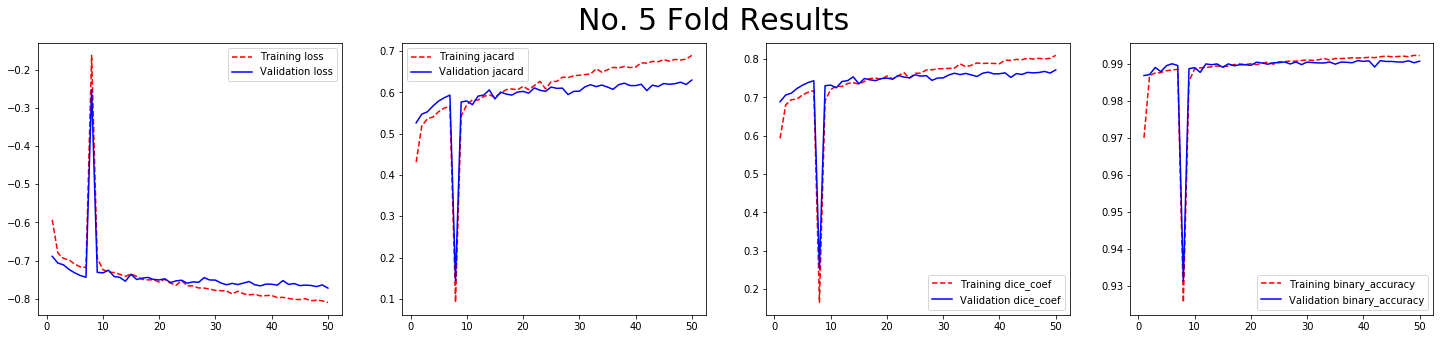

In [16]:
import pickle

for h, history in enumerate(histories):

    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
    fig.suptitle('No. ' + str(h+1) + ' Fold Results', fontsize=30)

    for k, key in enumerate(list(keys)[:len(keys)//2]):
        training = history.history[key]
        validation = history.history['val_' + key]

        epoch_count = range(1, len(training) + 1)

        axs[k].plot(epoch_count, training, 'r--')
        axs[k].plot(epoch_count, validation, 'b-')
        axs[k].legend(['Training ' + key, 'Validation ' + key])
        
    with open(str(h+1) + '_trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [17]:
print('average accuracy : ', np.mean(np.array(accuracies)), '+-', np.std(np.array(accuracies)))
print('average loss : ', np.mean(np.array(losses)), '+-', np.std(np.array(losses)))
print('average jacard : ', np.mean(np.array(jacards)), '+-', np.std(np.array(jacards)))
print('average dice_coe : ', np.mean(np.array(dicecoefs)), '+-', np.std(np.array(dicecoefs)))

average accuracy :  0.99075717 +- 0.0001515732
average loss :  -0.7683764897286892 +- 0.0033445918607915466
average jacard :  0.62527686 +- 0.004447916
average dice_coe :  0.76837647 +- 0.0033446315


In [18]:
model = load_model('1_unet_ner_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'jacard': jacard, 'dice_coef': dice_coef})

1 1502


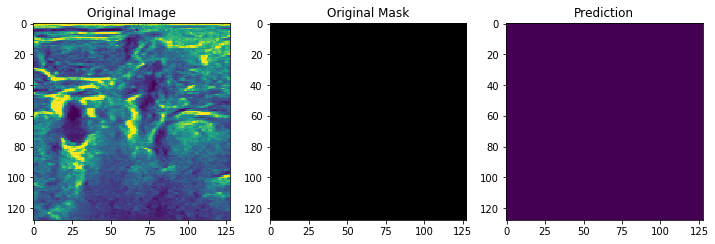

2 1088


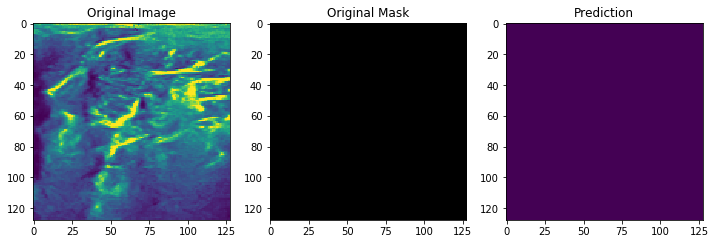

3 328


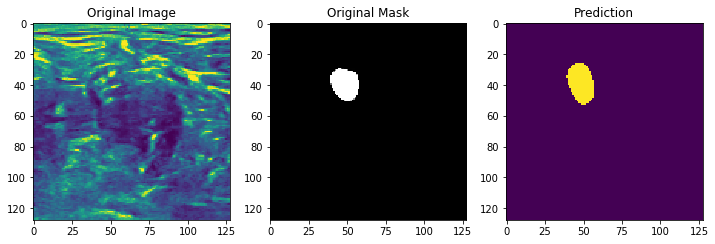

4 646


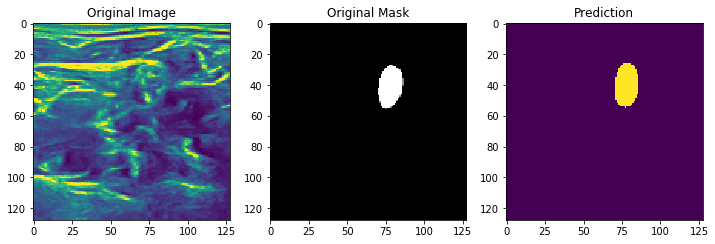

5 575


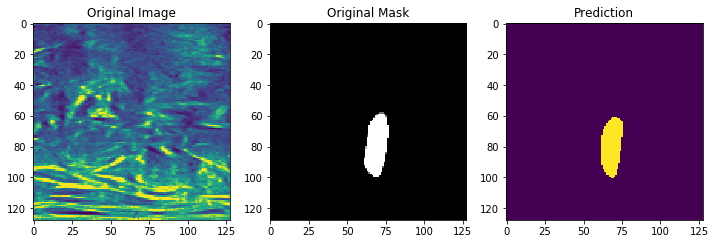

6 1976


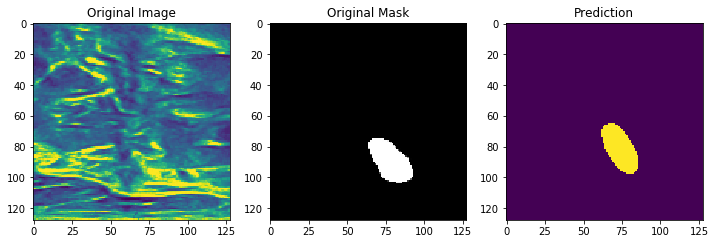

7 334


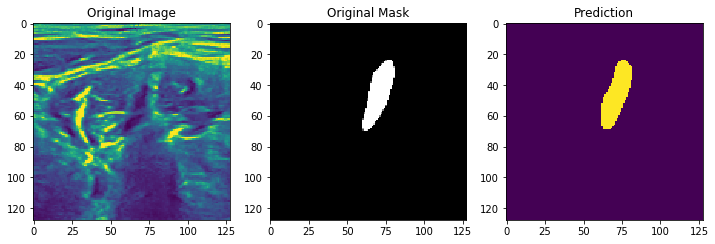

8 395


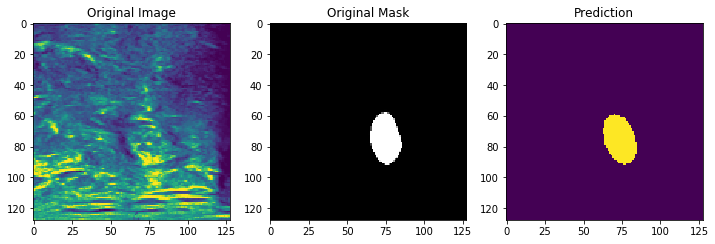

9 559


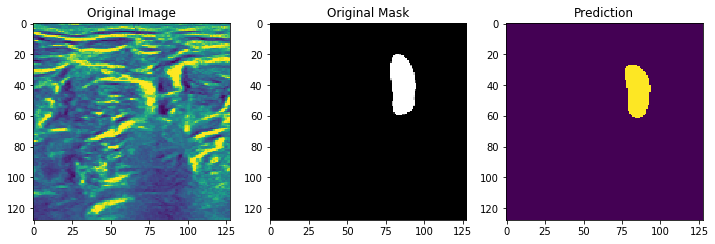

10 1785


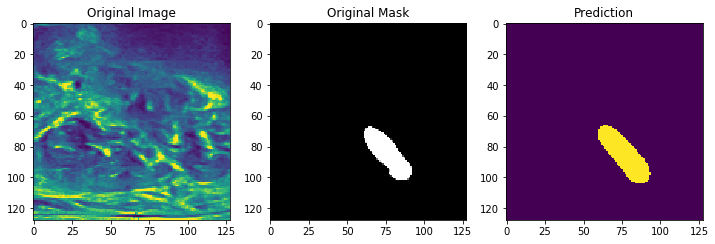

11 474


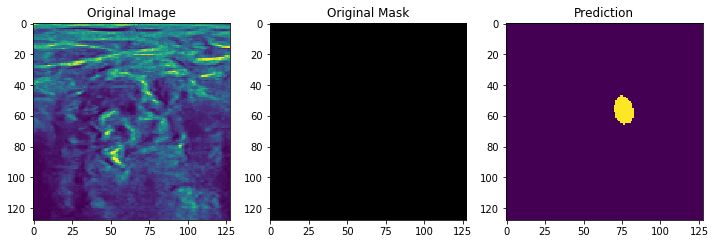

12 434


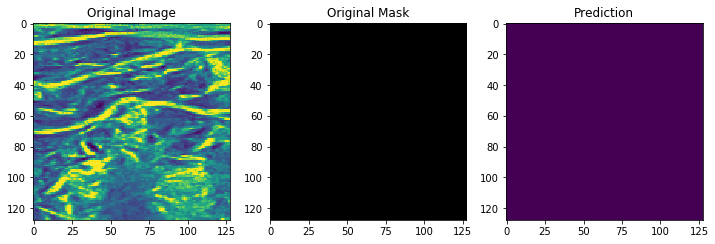

13 1226


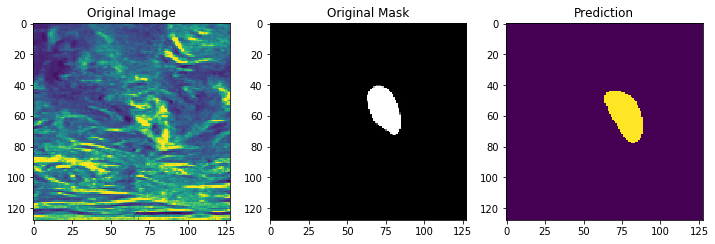

14 723


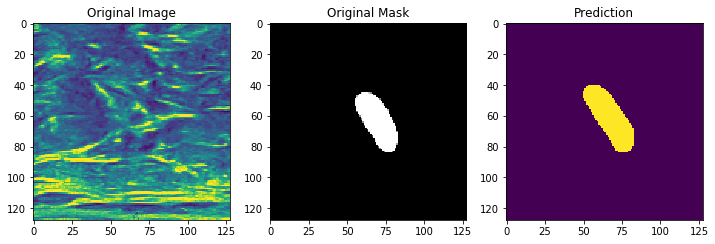

15 450


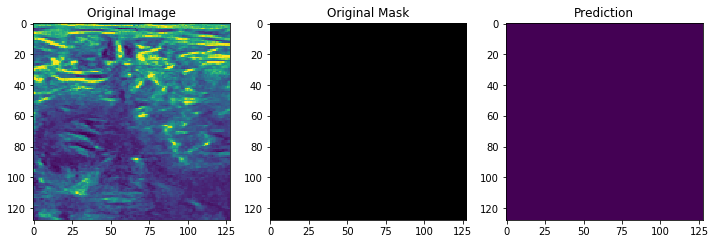

16 1074


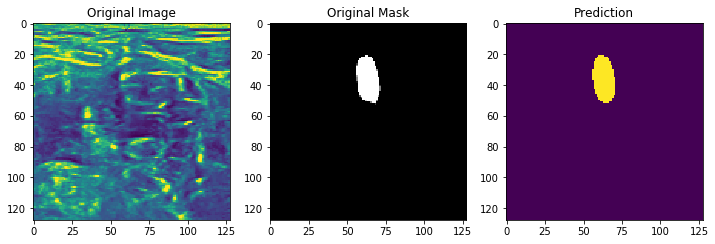

17 1386


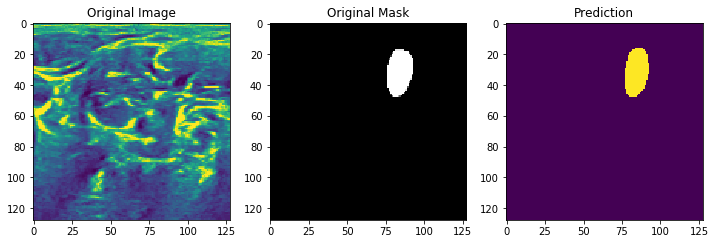

18 470


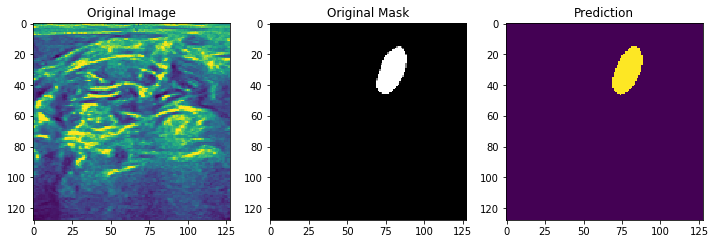

19 31


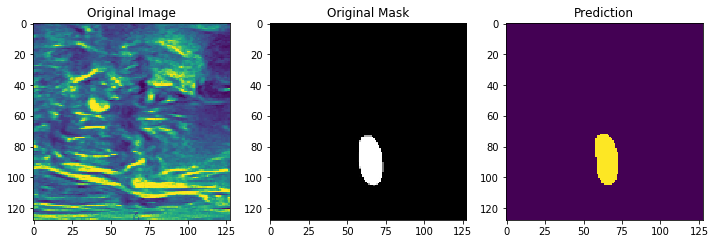

20 1969


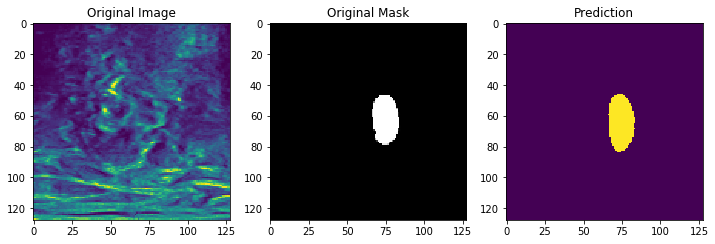

In [19]:
for i in range(20):
    index=np.random.randint(0,len(test_data_frame.index))
    print(i+1, index)
    img = cv2.imread(test_data_frame['filename'].iloc[index], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (height, width))
    img = img[np.newaxis, :, :, np.newaxis]
    img = img / 255
    pred = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.resize(cv2.imread(test_data_frame['mask'].iloc[index]), (height, width))))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [20]:
def prep(img):
    img = img.astype('float32')
    img = (img > 0.5).astype(np.uint8)  # threshold
    img = resize(img, (image_cols, image_rows), preserve_range=True)
    return img


def run_length_enc(label):
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])

In [21]:
path = "../input/ultrasound-nerve-segmentation/test/"
test_list = os.listdir(path)


sub = pd.read_csv("../input/ultrasound-nerve-segmentation/sample_submission.csv")

print("The number of test data : ", len(test_list))

# Sort the test set in ascending order.
reg = re.compile("[0-9]+")

temp1 = list(map(lambda x: reg.match(x).group(), test_list)) 
temp1 = list(map(int, temp1))

test_list = [x for _,x in sorted(zip(temp1, test_list))]

X_test = np.empty((len(test_list), height, width), dtype = 'float32')
for i, item in enumerate(test_list):
    image = cv2.imread("../input/ultrasound-nerve-segmentation/test/" + item, 0)
    image = cv2.resize(image, (height, width), interpolation = cv2.INTER_AREA)
    X_test[i] = image
X_test = X_test[:,:,:,np.newaxis] / 255

y_pred = model.predict(X_test)

The number of test data :  5508


In [22]:
!rm -r generated

In [23]:
rles = []
for i in range(X_test.shape[0]):
    img = y_pred[i, :, :, 0]
    img = img > 0.5
    img = resize(img, (420, 580), preserve_range=True)
    rle = run_length_enc(img)
    rles.append(rle)
    if i % 100 == 0:
            print('{}/{}'.format(i, X_test.shape[0]), end = "\r")


sub['pixels'] = rles
sub.to_csv("submission.csv", index = False)
